In [53]:
import networkx as nx
from gurobipy import *
import random
import numpy as np
import matplotlib.pyplot as plt 
import copy
import timeit
import time
import subprocess
import pickle
def plotp (m):
    data=m[::-1,:]
    heatmap = plt.pcolor(data, cmap=plt.cm.tab20, edgecolors='grey', linewidths=2)
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            plt.text(x + 0.5, y + 0.5, '%.0f' % data[y, x],
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.show()
def start (w,h):
    arr = np.zeros(w*h,dtype=int) 
    arr[:random.randrange(0, w*h+1)]  = 1
    np.random.shuffle(arr)
    g = np.reshape(arr,(w,h))
    return g
g=start(5,5)

In [54]:
def ln(g):
    def sechseck(g):
        st = timeit.default_timer()
        for i in range(len(g)-1):
            for j in range(len(g[0])-1):
                if g[i,j]>0:
                    if g[i+1,j]>0 and g[i,j+1]>0 and g[i+1,j+1]>0:
                        if (i+2 <len(g) and g[i+2,j]>0 and g[i+2,j+1]>0) or (j+2 < len(g[0]) and g[i,j+2]>0 and g[i+1,j+2]>0):
                            return True
        return False
    def rest(g):
        st = timeit.default_timer()
        for i in range(1,len(g)-1):
            for j in range(1,len(g[0])-1):
                if g[i,j-1]==1 and g[i-1,j]==1 and g[i,j]==1 and g[i+1,j]==1 and g[i,j+1]==1 and ((g[i-1,j+1]==1 and g[i+1,j-1]==1) or (g[i-1,j-1]==1 and g[i+1,j+1]==1)):
                    return True
        return False
    def cycles(g):
        st = timeit.default_timer()
        pixels=set()
        w,h = len(g),len(g[0])
        for i in range(w):
            for j in range(h):
                if g[i,j]==1:
                    pixels.add((i,j))
        while pixels:
            root = pixels.pop()
            stack = [root]
            pred = {root: root}
            used = {root: set()}
            while stack:
                z = stack.pop()
                zused = used[z]
                q=[]
                i,j = z
                if i>0 and g[i-1,j]==1:
                    q.append((i-1,j))
                if i<w-1 and g[i+1,j]==1:
                    q.append((i+1,j))
                if j>0 and g[i,j-1]==1:
                    q.append((i,j-1))
                if j<h-1 and g[i,j+1]==1:
                    q.append((i,j+1))
                for nb in q:
                    if nb not in used:
                        pred[nb] = z
                        stack.append(nb)
                        used[nb] = {z}
                    elif nb == z: continue
                    elif nb not in zused:
                        pn = used[nb]
                        cycle = [nb, z]
                        p = pred[z]
                        while p not in pn:
                            cycle.append(p)
                            p = pred[p]
                        cycle.append(p)
                        if len(cycle)>4: 
                            return True
                        used[nb].add(z)
            pixels -= set(pred)
        return False
    if sechseck(g) and rest(g) and cycles(g):
        return False
    else: return True

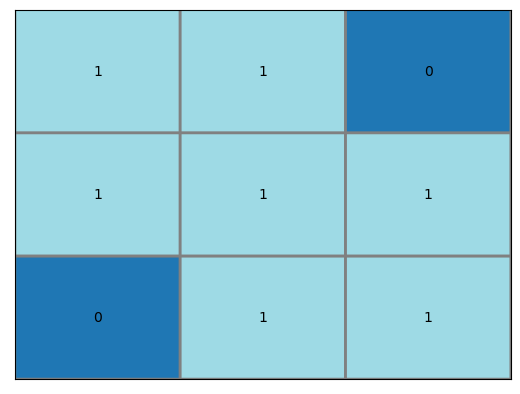

array([[1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0.],
       [1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0.],
       [0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
        1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 1.]])

In [55]:
def computeIpMatrix(g):

    def black(g):
        aa=0
        a=copy.deepcopy(g)
        b=1
        for i in range(len(g)):
            for j in range(len(g[0])):
                if g[i,j]==1:
                    a[i,j]=b
                    b+=1
                    aa+=1
        return a,aa
        
    a,b=black(g)
    w,h=len(g),len(g[0])
    rects=[]
    for i in range(0,w):
        for j in range(0,h):
            if g[i][j]!=0:
                d=h
                for ii in range(i,w):
                    for jj in range(j,d):
                        if g[ii][jj]==0: 
                            d=jj
                            break
                        if  i !=ii or j!=jj:
                            x=np.zeros(b)

                            for k in range(i,ii+1):
                                for kk in range(j,jj+1):
                                    x[a[k,kk]-1]=1
                            rects.append(x)
    rects=np.array(rects) 
    rects=np.transpose(rects)
    if len(rects)>0:
        rects=rects[~np.all(rects == 0, axis=1)]
        if len(rects)<b:
            for i in range(b-len(rects)):
                rects= np.vstack((rects,np.zeros(len(rects[0]))))
        A = np.concatenate((rects,np.identity(b)),axis=1)
    else:
        A=np.identity(b)

    return A

g=[[1,1,0],
 [1,1,1],
 [0,1,1]]
g=np.reshape(g,(3,3))
#g=start(5,5)
plotp(g)
computeIpMatrix(g)

In [56]:
def ip(g):
    st=timeit.default_timer()
    if len(g) == 0:
        return 0,0
    w,h=len(g),len(g[0])
    rect=[]
    gg = [[[] for i in range(h)] for j in range(w)]
    for i in range(w):
        for j in range(h):
            if g[i][j]!=0:
                d=h
                for ii in range(i,w):
                    for jj in range(j,d):
                        if g[ii][jj]==0: 
                            d=jj
                            break
                        for iii in range(i,ii+1):
                            for jjj in range(j,jj+1):
                                gg[iii][jjj].append((i,j,ii,jj))
                        rect.append((i,j,ii,jj))
    rechte=timeit.default_timer()-st
    m = Model()
    m.Params.OutputFlag=0
    rects = m.addVars(rect,vtype=GRB.BINARY,name='Rects')
    st=timeit.default_timer()
    for i in range(w):
        for j in range(h):
            if g[i,j]!=0:
                m.addConstr(sum(rects[x] for x in gg[i][j])==1) 
    m.setObjective(sum(rects[x]*(x[2]-x[0]+1)*(x[3]-x[1]+1)*(x[2]-x[0]+1)*(x[3]-x[1]+1) for x in rect), GRB.MAXIMIZE)
    m.Params.Heuristics=0
    m.Params.Presolve=0
    m.optimize()
    return m.objVal, m.Runtime

In [66]:
stepsize = range(5,26,5) # for real data
stepsize = range(2,4,1) # for testing

wdh = 5

timeUnbalanced = [[] for x in stepsize]
timeBalanced = [[] for x in stepsize]

for z in range(wdh):
    print("round",z+1,"of",wdh)
    i = 0
    for x in stepsize:

        fileObj2 = open('fields%s.obj'%x, 'rb')
        fields = pickle.load(fileObj2)
        fileObj2.close()

        for j in range(len(fields)):
            time = ip(computeIpMatrix(np.reshape(fields[j],(x,x))))[1]
            
            if ln(fields[j]):
                timeBalanced[i].append(time)
            else:
                timeUnbalanced[i].append(time)
        i = i+1


round 1 of 5
round 2 of 5
round 3 of 5
round 4 of 5
round 5 of 5


In [67]:
resultsTimeBalanced = []
for array in timeBalanced:
    resultsTimeBalanced.append(sum(array)/wdh)
print("Total solving times for the balanced problem fields")
display(resultsTimeBalanced)

resultsTimeUnbalanced = []
for array in timeUnbalanced:
    resultsTimeUnbalanced.append(sum(array)/wdh)
print("Total solving times for the unbalanced problem fields")

display(resultsTimeUnbalanced)

Total solving times for the balanced problem fields


[0.07700581550598144, 0.0652472972869873]

Total solving times for the unbalanced problem fields


[0.0, 0.020616579055786132]

In [68]:
resultsTimeBalanced = []
for array in timeBalanced:
    resultsTimeBalanced.append(sum(array)/wdh/len(array))
print("Average solving times for the balanced problem fields")
display(resultsTimeBalanced)

resultsTimeUnbalanced = []
for array in timeUnbalanced:
    resultsTimeUnbalanced.append(sum(array)/wdh/len(array))
print("Average solving times for the unbalanced problem fields")

display(resultsTimeUnbalanced)


Average solving times for the balanced problem fields


[0.00015401163101196288, 0.000146623139970758]

ZeroDivisionError: float division by zero

In [62]:
gg = []
for i in range(100):
    gg.append(start(2,2))
fileObj = open('fields2.obj', 'wb')
pickle.dump(gg,fileObj)
fileObj.close()